In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import sys
warnings.simplefilter('ignore')
matplotlib.rcParams['figure.dpi'] = 100
sns.set()
%matplotlib inline

In [2]:
metadata_df = pd.read_csv('/Users/yuyizhang/Documents/forecasting/Energy_Data/ASHRAE_data/building_metadata.csv')
train_df = pd.read_csv('/Users/yuyizhang/Documents/forecasting/Energy_Data/ASHRAE_data/train.csv', parse_dates=['timestamp'])
weather_train_df = pd.read_csv('/Users/yuyizhang/Documents/forecasting/Energy_Data/ASHRAE_data/weather_train.csv', parse_dates=['timestamp'])

In [3]:
print(metadata_df.shape)
print(train_df.shape)
print(weather_train_df.shape)

(1449, 6)
(20216100, 4)
(139773, 9)


In [4]:
train = train_df.merge(metadata_df, on='building_id', how='left')
train = train.merge(weather_train_df, on=['site_id', 'timestamp'], how='left')

In [5]:
del weather_train_df, metadata_df
gc.collect();

In [6]:
#format datetime
train['timestamp']= pd.to_datetime(train['timestamp'],format='%Y-%m-%d %H:%M:%S')

In [7]:
# count the number of NaN
def find_nan(df):
    nan_lists = {}
    for col in df.columns:
        nan_counter = 0
        for nan in df[col].isnull():
            if nan:
                nan_counter+=1
                nan_lists[col] = nan_counter
    for k, v in nan_lists.items():
        print('Feature"{}" has {} NaN'.format(k,v))
        print('Feature"{}" has {} NaN'.format(k,v/len(df)))

find_nan(train)

Feature"year_built" has 12127645 NaN
Feature"year_built" has 0.5999003269671203 NaN
Feature"floor_count" has 16709167 NaN
Feature"floor_count" has 0.826527718006935 NaN
Feature"air_temperature" has 96658 NaN
Feature"air_temperature" has 0.004781238715677109 NaN
Feature"cloud_coverage" has 8825365 NaN
Feature"cloud_coverage" has 0.43655131306236117 NaN
Feature"dew_temperature" has 100140 NaN
Feature"dew_temperature" has 0.00495347767373529 NaN
Feature"precip_depth_1_hr" has 3749023 NaN
Feature"precip_depth_1_hr" has 0.18544739094088375 NaN
Feature"sea_level_pressure" has 1231669 NaN
Feature"sea_level_pressure" has 0.06092515371411895 NaN
Feature"wind_direction" has 1449048 NaN
Feature"wind_direction" has 0.0716779200736047 NaN
Feature"wind_speed" has 143676 NaN
Feature"wind_speed" has 0.007107008770237583 NaN


In [8]:
train_1 = train.dropna(axis = 0, how = 'any')

In [9]:
# Below function extracts date related features from datetime
def create_date_featues(df):

    df['Year'] = pd.to_datetime(train_1['timestamp']).dt.year
    df['Month'] = pd.to_datetime(train_1['timestamp']).dt.month
    df['Day'] = pd.to_datetime(train_1['timestamp']).dt.day
    df['Hour'] = pd.to_datetime(train_1['timestamp']).dt.hour
    df['Minute'] = pd.to_datetime(train_1['timestamp']).dt.minute
    
    return df

In [10]:
train_1 = create_date_featues(train_1)

In [11]:
for col in ['meter']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [12]:
for col in ['primary_use']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [13]:
for col in ['floor_count']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [14]:
for col in ['cloud_coverage']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [15]:
for col in ['year_built']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [16]:
for col in ['precip_depth_1_hr']:
    train_1 = pd.get_dummies(train_1, columns=[col])

In [17]:
train_1.shape

(321728, 102)

In [18]:
df_1 = train_1[:int(len(train_1)*0.01)]

In [19]:
train_set = df_1[ : int(len(df_1)*0.7)]
test_set = df_1[int(len(df_1)*0.7) : ]

In [20]:
print(train_set.shape)
print(test_set.shape)

(2251, 102)
(966, 102)


In [21]:
x_train1 = train_set.drop(columns={'building_id','site_id','timestamp','meter_reading'},axis=1)
y_train1 = train_set.loc[:,['meter_reading']]

x_test1=test_set.drop(columns={'building_id','site_id','timestamp','meter_reading'},axis=1)
y_test1=test_set.loc[:,['meter_reading']]

In [22]:
import lightgbm as lgb

lgb_merge_df = lgb.LGBMRegressor(objective='regression')
lgb_merge_df.fit(x_train1, y_train1,eval_metric="rmse", 
    eval_set=[(x_train1, y_train1)],
    verbose=True, 
    early_stopping_rounds = 1000)

[1]	training's rmse: 228.87	training's l2: 52381.3
Training until validation scores don't improve for 1000 rounds
[2]	training's rmse: 206.607	training's l2: 42686.5
[3]	training's rmse: 186.639	training's l2: 34834.1
[4]	training's rmse: 168.73	training's l2: 28469.9
[5]	training's rmse: 152.679	training's l2: 23310.9
[6]	training's rmse: 138.319	training's l2: 19132.3
[7]	training's rmse: 125.446	training's l2: 15736.7
[8]	training's rmse: 113.927	training's l2: 12979.2
[9]	training's rmse: 103.659	training's l2: 10745.1
[10]	training's rmse: 94.4937	training's l2: 8929.06
[11]	training's rmse: 86.3671	training's l2: 7459.27
[12]	training's rmse: 78.9188	training's l2: 6228.18
[13]	training's rmse: 72.3049	training's l2: 5227.99
[14]	training's rmse: 66.4279	training's l2: 4412.67
[15]	training's rmse: 61.2453	training's l2: 3750.99
[16]	training's rmse: 56.632	training's l2: 3207.18
[17]	training's rmse: 52.5357	training's l2: 2760
[18]	training's rmse: 48.9465	training's l2: 2395.7

LGBMRegressor(objective='regression')

In [23]:
from sklearn.metrics import mean_squared_error,r2_score
from math import sqrt

In [24]:
pred_lgb_df=lgb_merge_df.predict(x_test1)

In [25]:
r2_score(y_test1,pred_lgb_df)

0.9800203164363276

In [26]:
np.sqrt(mean_squared_error(y_test1,pred_lgb_df))

36.82394998464316

In [27]:
import shap

In [28]:
explainer_xgb_static = shap.TreeExplainer(lgb_merge_df)
shap_xgb_values = explainer_xgb_static(x_train1)

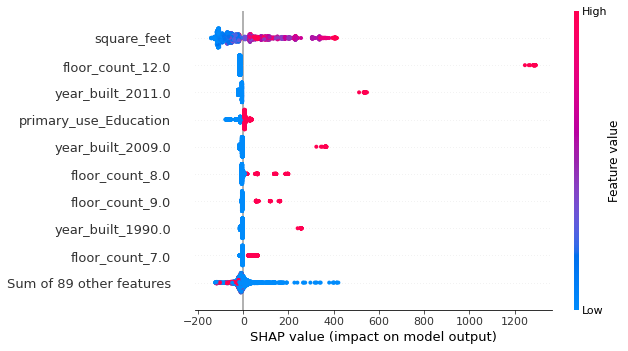

In [29]:
sns.reset_orig()
shap.plots.beeswarm(shap_xgb_values)

In [30]:
df_more = train_1[int(len(df_1)*0.7) : ]

In [31]:
train_more = df_more.drop(columns={'building_id','site_id','timestamp','meter_reading'},axis=1)
test_more = df_more.loc[:,['meter_reading']]

In [32]:
pred_xgb_more=lgb_merge_df.predict(train_more)

In [33]:
r2_score(test_more,pred_xgb_more)

0.9370368118506329

In [34]:
np.sqrt(mean_squared_error(test_more,pred_xgb_more))

71.90831074367748

In [49]:
int(len(pred_xgb_more))

319477

In [40]:
acc = []

for i in range(0,int(len(pred_xgb_more)/100)):
    accuracy = r2_score(test_more[0:100+i*100],pred_xgb_more[0:100+i*100])
    
    acc.append(accuracy)

    percent = float(i)*100/int(len(test_more)/100)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    #sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

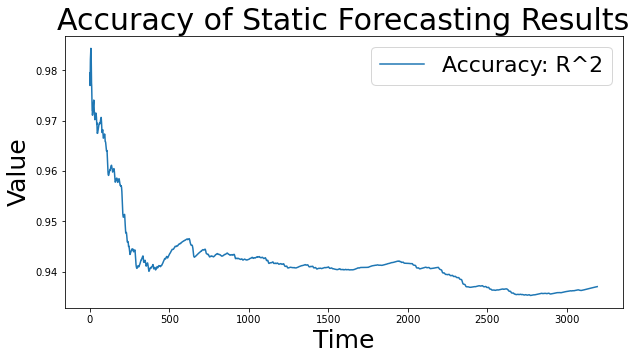

In [41]:
fig = plt.figure(figsize=(10,5))
sns.reset_orig()
plt.title('Accuracy of Static Forecasting Results', fontsize = 30)
plt.plot(acc[:4500],label = 'Accuracy: R^2')
plt.xlabel('Time', fontsize = 25)
plt.ylabel('Value', fontsize = 25)
plt.legend(fontsize = 22)

plt.show()

In [42]:
df_features = train_1.drop(columns={'building_id','site_id','timestamp','meter_reading'},axis=1)
df_target = train_1.loc[:,['meter_reading']]

In [43]:
lgb_merge_df = lgb.LGBMRegressor(objective='regression')

In [44]:
L = int(len(df_1)*0.7)
S = int(len(df_1)*0.3)

In [45]:
prediction_results = []

for i in range(0,int(len(test_more)/S)):
    df_x_train = df_features[ i*S : L + i*S]
    df_y_train = df_target[ i*S : L + i*S]
    
    df_x_val = df_features[L + i*S : L + i*S + S]
    df_y_val = df_target[L + i*S : L + i*S + S]
    
    
    
    lgb_merge_df.fit(df_x_train, df_y_train,eval_metric="rmse", 
        eval_set=[(df_x_train, df_y_train)],
        verbose=False,
        early_stopping_rounds = 1000)
    
    pred_dynamic=lgb_merge_df.predict(df_x_val)
    
    prediction_results.append(pred_dynamic)

    percent = float(i)*500/float(len(test_more)/100)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

In [46]:
pred = np.array(prediction_results)

In [47]:
pred_results =pred.flatten()

In [51]:
int(len(pred_results)/100)

3194

In [59]:
acc_dymanic = []

for i in range(int(len(pred_results)/100)):
    accuracy_dy = r2_score(test_more[0:100+i*100],pred_results[0:100+i*100])
    
    acc_dymanic.append(accuracy_dy)
    
    percent = float(i)*100/float(len(test_more)/100)
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    #sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

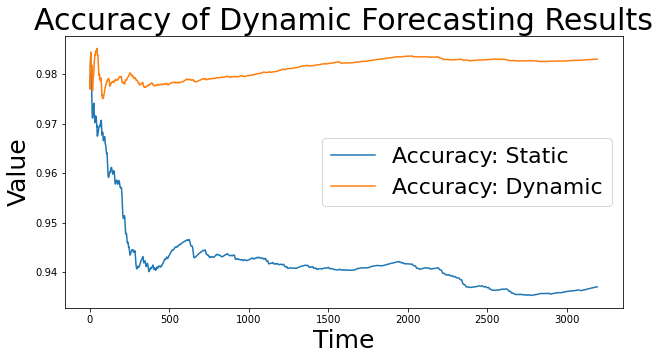

In [60]:
fig = plt.figure(figsize=(10,5))
sns.reset_orig()
plt.title('Accuracy of Dynamic Forecasting Results', fontsize = 30)
plt.plot(acc,label = 'Accuracy: Static')
plt.plot(acc_dymanic,label = 'Accuracy: Dynamic')
plt.xlabel('Time', fontsize = 25)
plt.ylabel('Value', fontsize = 25)
plt.legend(fontsize = 22)

plt.show()

In [79]:
import shap

In [55]:
df_shap_results = pd.DataFrame()

for i in range(0,int(len(test_more)/S)):
    df_x_train = df_features[ i*S : L + i*S]
    df_y_train = df_target[ i*S : L + i*S]
    
    df_x_val = df_features[L + i*S : L + i*S + S]
    df_y_val = df_target[L + i*S : L + i*S + S]
    
    lgb_merge_df.fit(df_x_train, df_y_train,eval_metric="rmse", 
        eval_set=[(df_x_train, df_y_train)],
        verbose=False,
        early_stopping_rounds = 1000)
    
    explainer_xgb_dynamic = shap.TreeExplainer(lgb_merge_df)
    shap_xgb_values = explainer_xgb_dynamic(df_x_train)
    shap_xgb_values = pd.DataFrame(shap_xgb_values.values)
    
    shap_values_update = []
    for n in range(0, len(shap_xgb_values.columns)):
        each_shap_value = (abs(shap_xgb_values[n]).sum())/len(shap_xgb_values)
        
        shap_values_update.append(each_shap_value)
    
    df_shap_results[i] = shap_values_update
    del shap_values_update

    percent = float(i)*100/float((len(test_more)/500))
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();


In [89]:
prediction_results_up = []

df_shap_update = pd.DataFrame()
df_cols = pd.DataFrame(x_train1.columns)
df_shap_update['Features'] = df_cols[0]

for i in range(0,len(df_shap_results.columns)) :
    
    df_shap_update['shap_value'] = df_shap_results[i]
    df_shap = df_shap_update.sort_values(by = 'shap_value').reset_index()
    
    df_x_train = df_features[ i*S : L + i*S]
    df_y_train = df_target[ i*S : L + i*S]
    
    df_x_val = df_features[L + i*S : L + i*S + S]
    df_y_val = df_target[L + i*S : L + i*S + S]
    
    

    remove_features = df_shap['Features'][0: 40].values.tolist()
    
    df_x_train_up = df_x_train.drop(remove_features,axis=1)
    df_x_val_up = df_x_val.drop(remove_features,axis=1)
    
    lgb_merge_df.fit(df_x_train_up, df_y_train,eval_metric="rmse", 
        eval_set=[(df_x_train_up, df_y_train)],
        verbose=False,
        early_stopping_rounds = 1000)
    
    pred_dynamic_up=lgb_merge_df.predict(df_x_val_up)
    
    prediction_results_up.append(pred_dynamic_up)

    percent = float(i)*100/float(len(df_shap_results.columns))
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

In [90]:
pred_up = np.array(prediction_results_up)

In [91]:
pred_results_up =pred_up.flatten()

In [92]:
acc_dymanic_up = []

for i in range(int(len(pred_results_up)/100)):
    accuracy_dy_up = r2_score(test_more[0:100+i*100],pred_results_up[0:100+i*100])
    
    acc_dymanic_up.append(accuracy_dy_up)
    
    percent = float(i)*100/float((len(test_more)/100))
    sys.stdout.write("%.4f"%percent);
    sys.stdout.write("%\r");
    #sys.stdout.flush();

sys.stdout.write("100%_finish!\r");
sys.stdout.flush();

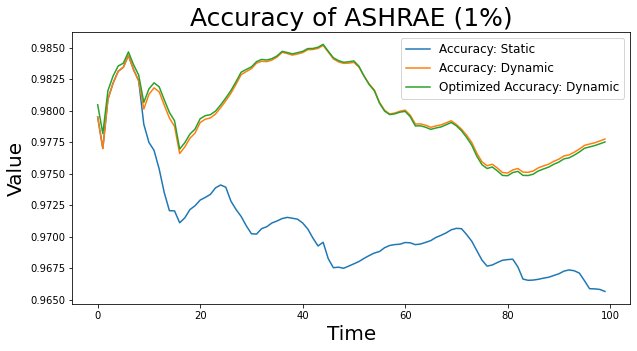

In [100]:
fig = plt.figure(figsize=(10,5))
plt.title('Accuracy of ASHRAE (1%)', fontsize = 25)
plt.plot(acc[:100],label = 'Accuracy: Static')
plt.plot(acc_dymanic[:100],label = 'Accuracy: Dynamic')
plt.plot(acc_dymanic_up[:100],label = 'Optimized Accuracy: Dynamic')
plt.xlabel('Time', fontsize = 20)
plt.ylabel('Value', fontsize = 20)
plt.legend(fontsize = 12)

plt.show()